<a href="https://colab.research.google.com/github/7sr7/Projs-in-AI-HW-5/blob/main/Silvestre_Projs_in_AI_HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Silvestre Ronin

Professor Mushtaque

PROJECTS IN AI & MACHINE LRNG - CSCI 4170 - 01

2025 07 31

In [1]:
# importing required libraries...
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel
from wordcloud import WordCloud
from collections import Counter
from numpy import dot
from numpy.linalg import norm
import difflib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from numpy.linalg import norm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import tensorflow as tf
from collections import Counter
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
import dask.bag as db
import dask.array as da
from dask.diagnostics import ProgressBar
import random
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import copy


import time
import warnings
warnings.filterwarnings("ignore")

In [4]:
# mounting to google drive...
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Task1...


## Part1...

The dataset that I have chosen is the following:

https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza/data

The task is a binary image classification problem

### Preprocessing Data...

In [5]:
# reading data set...
data = "/content/drive/MyDrive/pizza_not_pizza/"

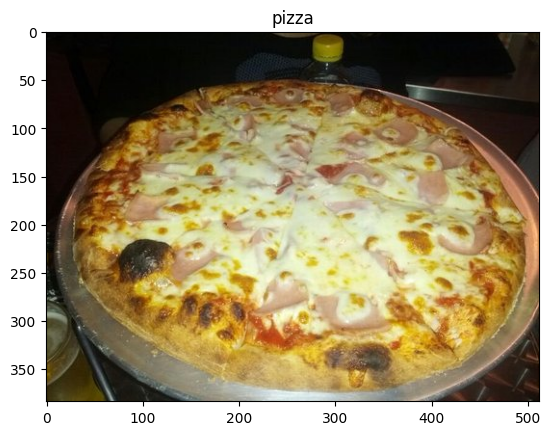

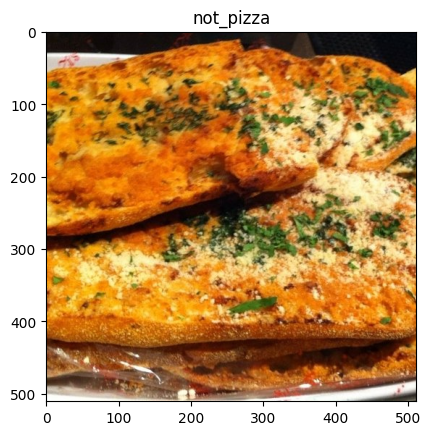

In [6]:
# visualizing random sample of each class...
classes = ['pizza', 'not_pizza']
for cls in classes:
  folder = os.path.join(data, cls)
  sample = random.choice(os.listdir(folder))
  img = Image.open(os.path.join(folder, sample))
  plt.imshow(img)
  plt.title(cls)
  plt.show()

In [7]:
# ('*.*') means that all image formats can be retrieved...
paths = [path.parts[-2:] for path in Path(data).rglob('*.*')]


# creating dataframe...
df = pd.DataFrame(data=paths, columns=['Class','Images'])
df = df.sort_values('Class',ascending=True)
df.reset_index(drop=True, inplace=True)

df

,Class,Images
0,not_pizza,99088.jpg
1,not_pizza,240787.jpg
2,not_pizza,2354658.jpg
3,not_pizza,2438063.jpg
4,not_pizza,215349.jpg
...,...,...
1961,pizza,3441394.jpg
1962,pizza,3550805.jpg
1963,pizza,3456604.jpg
1964,pizza,3678290.jpg


In [8]:
# printing numerical stats about the data...
print(f"Total Images: {len(df.Images)}")
print(f"Total Classes: {len(df['Class'].value_counts())} \n")


print('Total Number of Images in Each Class')
print(df['Class'].value_counts())

Total Images: 1966
Total Classes: 2 

Total Number of Images in Each Class
Class
not_pizza    983
pizza        983
Name: count, dtype: int64


Text(0, 0.5, 'Count Image')

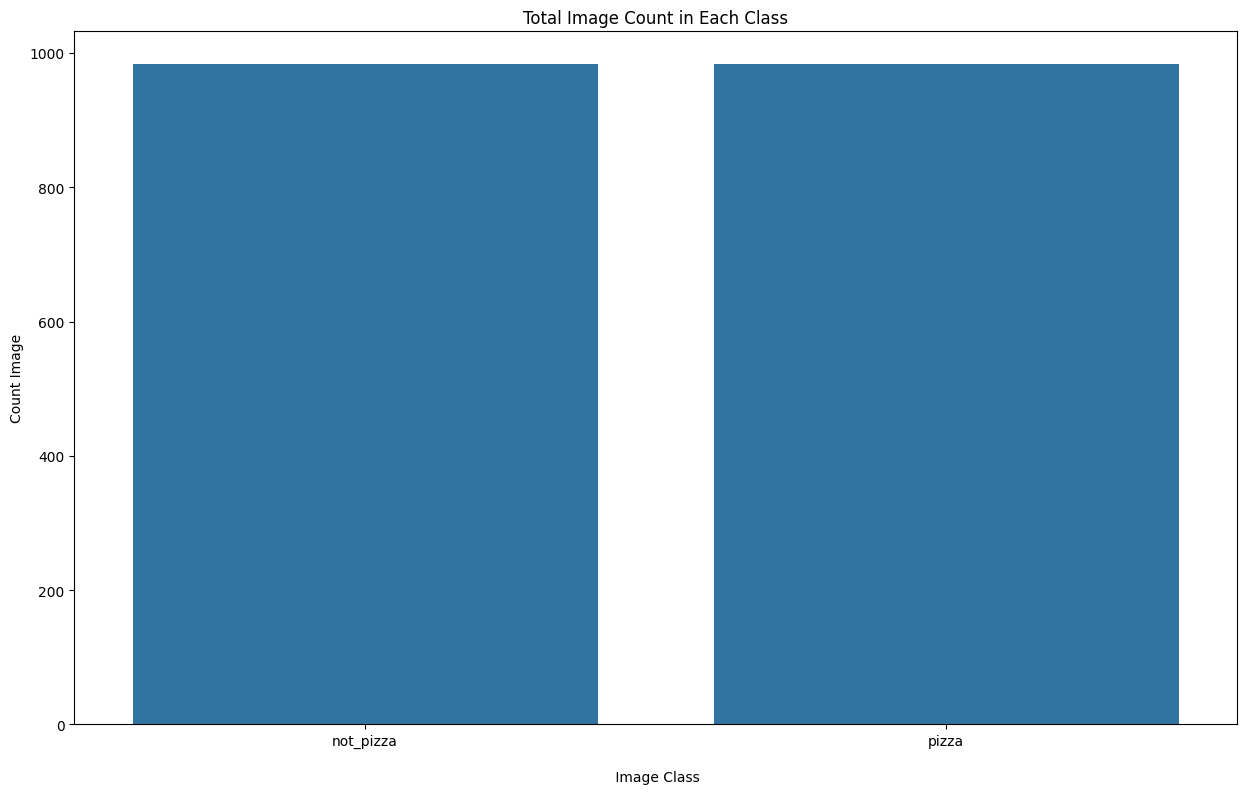

In [9]:
# plotting total number of images in each class
# visually shows us if data is balanced or not...
fig, ax = plt.subplots(figsize=(15,9))
sns.countplot(data=df, x='Class')
plt.title('Total Image Count in Each Class')
plt.xlabel('\n Image Class')
plt.ylabel('Count Image')

In [10]:
directories = {
    "not_pizza": "/content/drive/MyDrive/pizza_not_pizza/not_pizza/",
    "pizza": "/content/drive/MyDrive/pizza_not_pizza/pizza/"
}

def getDims(file):
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

[########################################] | 100% Completed | 35.38 s
[########################################] | 100% Completed | 25.84 s


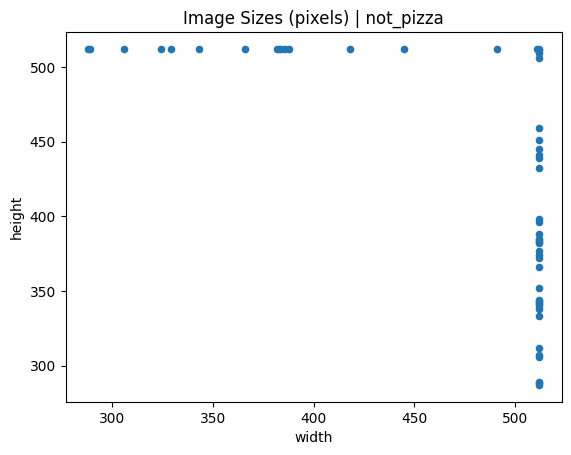

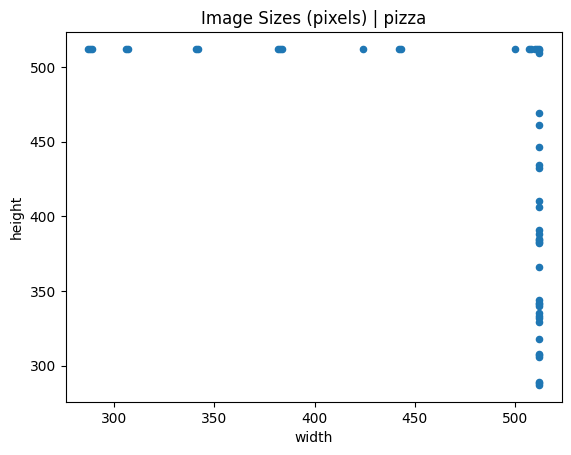

In [11]:
# plotting image dimensions for each class...
for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = db.from_sequence(filelist).map(getDims)

  with ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(n))

In [12]:
# we observe from the above graphs that our images are not all the same dimensions
# we need them to be in order to feed them into our CNN
# so, we need to resize all of them to a consistent size...

transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root=data, transform=transform)

In [13]:
# calculating mean and stdev px vals of each img to be used in normalization...

all_pixels = torch.cat([img for img, _ in dataset], dim=1)
imgMean = all_pixels.mean().item()
imgStd = all_pixels.std().item()
print(f"Mean: {imgMean}, Std: {imgStd}")

Mean: 0.43468132615089417, Std: 0.2694951593875885


In [14]:
# adding normalization now...

transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[imgMean], std=[imgStd])
])
dataset = datasets.ImageFolder(root=data, transform=transform)

In [15]:
# creating dataloader object from dataset...

loader = DataLoader(dataset, batch_size=64, shuffle=True)
images, labels = next(iter(loader))

# sanity check to make sure that all imgs are same size...
# 3 means that we have 3 dimensions of r,g,b...
print("Batch shape:", images.shape)

Batch shape: torch.Size([64, 3, 64, 64])


In [16]:
# train, val, test split on data... i am choosing a 80 10 10 split
trainSize = int(0.8 * len(dataset))
valSize = int(0.1 * len(dataset))
testSize = len(dataset) - trainSize - valSize

trainSet, valSet, testSet = random_split(dataset, [trainSize, valSize, testSize])

In [17]:
# creating dataloader for train, val, and test sets...
trainLoader = DataLoader(trainSet, batch_size=64, shuffle=True)
valLoader = DataLoader(valSet, batch_size=64, shuffle=False)
testLoader = DataLoader(testSet, batch_size=64, shuffle=False)

In [18]:
# sanity check...
images, labels = next(iter(trainLoader))
print("Batch shape:", images.shape)
print("Labels:", labels[:10])

Batch shape: torch.Size([64, 3, 64, 64])
Labels: tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 0])


### Making the CNN...

In [ ]:
# CNN declaration...
class myCNN(nn.Module):
  def __init__(self):
    super(myCNN, self).__init__()
    # defining convolutoin layers and pooling...

    # first conv layer - takes as input: 3 x 64 x 64 (depth of 3 since this is rgb and not grayscale)
    self.conv1 = nn.Conv2d(3, 32, 3, stride = 1, padding=1)

    # 3 x 64 x 64 --> 32 x 64 x 64 (apply 1st conv) --> 32 z 32 x 32 (max pooling)

    # second conv layer - takes as input: 32 x 32 x 32
    self.conv2 = nn.Conv2d(32, 64, 3, stride = 1, padding=1)

    # 32 x 32 x 32 --> 64 x 32 x 32 (apply 2nd conv) --> 64 x 16 x 16 (max pooling)

    # 3rd conv layer - takes as input 64 x 16 x 16
    if False:
      self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding=1)

    # 64 x 16 x 16 --> 128 x 16 x 16 (apply 3rd conv) --> 128 x 8 x 8 (max pooling)

    # to help with overfitting...
    self.dropout = nn.Dropout(0.5)
    self.conv_dropout = nn.Dropout2d(0.2)

    self.pool = nn.MaxPool2d(2, 2)



    # defining the regular NN after flattening...
    # so input to this NN now is 128 * 8 * 8 (we flatten), hidden layer is size 128
    if False:
      self.fc1 = nn.Linear(128 * 8 * 8, 32)
    else:
      self.fc1 = nn.Linear(64 * 16 * 16, 32)


    # hidden layer to output layer is 128 to 1 (since this si binary classification)
    self.fc2 = nn.Linear(32, 1)


  # i have chosen to use relu as my nonlinear activation and then to apply sigmoid
  # as my final activation (+ BCELoss) since this is a binary classificaiton problem
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.conv_dropout(x)

    x = self.pool(F.relu(self.conv2(x)))
    x = self.conv_dropout(x)


    if False:
      x = self.pool(F.relu(self.conv3(x)))
      x = self.conv_dropout(x)


    x = x.view(x.size(0), -1)


    x = F.relu(self.fc1(x))
    x = self.dropout(x)

    x = self.fc2(x)
    # x = self.dropout(x)
    x = torch.sigmoid(x)

    return x


In [ ]:
# CNN initialization...
model = myCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
numEpochs = 5

In [ ]:
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_index = -1
patience = 3
trigger_times = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(numEpochs):
  # training...
  model.train()
  correct = 0
  total = 0
  total_train_loss = 0

  for images, labels in trainLoader:
    labels = labels.float().unsqueeze(1)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()

    preds = (outputs >= 0.5).float()
    correct += (preds == labels).sum().item()
    total += labels.size(0)

  acc = correct / total
  avg_train_loss = total_train_loss / len(trainLoader)
  train_losses.append(avg_train_loss)


  print(f"Epoch {epoch+1}/{numEpochs}:")
  print(f"Train Loss: {avg_train_loss:.4f} — Train Acc: {acc:.4f}")


  # validation...
  model.eval()
  val_correct = 0
  val_total = 0
  total_val_loss = 0

  y_true = []
  y_pred = []
  with torch.no_grad():
    for images, labels in valLoader:
      labels = labels.float().unsqueeze(1)

      outputs = model(images)
      loss = criterion(outputs, labels)

      preds = (outputs >= 0.5).float()
      val_correct += (preds == labels).sum().item()
      val_total += labels.size(0)

      y_true.extend(labels.cpu().numpy())
      y_pred.extend(preds.cpu().numpy())

      total_val_loss += loss.item()


  avg_val_loss = total_val_loss / len(valLoader)
  val_losses.append(avg_val_loss)

  val_acc = val_correct / val_total

  print(f"Val Loss: {avg_val_loss:.4f} — Val Acc: {val_acc:.4f}\n")

  # print("Confusion Matrix:")
  # cm = confusion_matrix(y_true, y_pred)
  # print(cm)

  # print("\nEvaluation Metrics:")
  # print(classification_report(y_true, y_pred))
  print("\n\n")


  # early stopping to prevent overfitting...
  if (avg_val_loss < best_val_loss):
    best_val_loss = avg_val_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    best_index = epoch + 1

    # reset...
    trigger_times = 0

  else:
    print("Here...")
    trigger_times += 1
    if trigger_times >= patience:
      print("Early stopping triggered... loading best weights...")
      break


model.load_state_dict(best_model_wts)
print(f"Best Weights at index {best_index} with a validation loss of {best_val_loss}")

Epoch 1/5:
Train Loss: 0.6841 — Train Acc: 0.5789
Val Loss: 0.6852 — Val Acc: 0.5918




Epoch 2/5:
Train Loss: 0.6579 — Train Acc: 0.6209
Val Loss: 0.6615 — Val Acc: 0.6378




Epoch 3/5:
Train Loss: 0.6340 — Train Acc: 0.6425
Val Loss: 0.6118 — Val Acc: 0.6837




Epoch 4/5:
Train Loss: 0.6163 — Train Acc: 0.6565
Val Loss: 0.5938 — Val Acc: 0.7143




Epoch 5/5:
Train Loss: 0.6006 — Train Acc: 0.6959
Val Loss: 0.5732 — Val Acc: 0.7143




Best Weights at index 5 with a validation loss of 0.5731678754091263


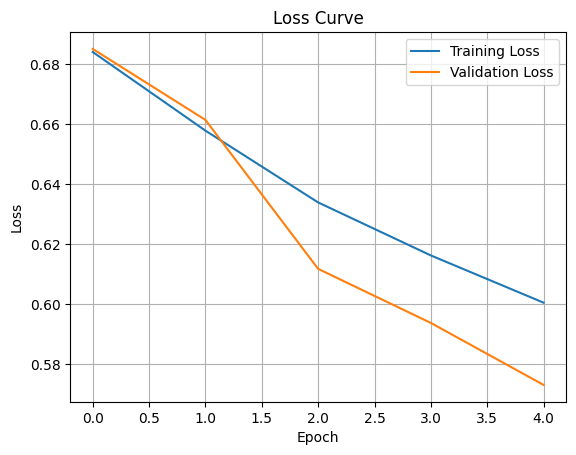

In [ ]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# testing...
model.eval()

test_correct = 0
test_total = 0
total_test_loss = 0

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in testLoader:
    labels = labels.float().unsqueeze(1)

    outputs = model(images)
    loss = criterion(outputs, labels)

    preds = (outputs >= 0.5).float()
    test_correct += (preds == labels).sum().item()
    test_total += labels.size(0)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

    total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(testLoader)
test_acc = test_correct / test_total

print(f"Test Loss: {avg_test_loss:.4f} — Test Acc: {test_acc:.4f}\n")

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# [[TN  FP]
#  [FN  TP]]

print("\nEvaluation Metrics:")
print(classification_report(y_true, y_pred))

Test Loss: 0.5715 — Test Acc: 0.7273

Confusion Matrix:
[[77 16]
 [38 67]]

Evaluation Metrics:
              precision    recall  f1-score   support

         0.0       0.67      0.83      0.74        93
         1.0       0.81      0.64      0.71       105

    accuracy                           0.73       198
   macro avg       0.74      0.73      0.73       198
weighted avg       0.74      0.73      0.73       198



## Part2...

In [28]:
vae_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()   # values in [0,1]
])

vae_dataset = datasets.ImageFolder(root=data, transform=vae_transform)

vae_train, vae_val, vae_test = random_split(vae_dataset, [trainSize, valSize, testSize])
vae_train_loader = DataLoader(vae_train, batch_size=32, shuffle=True)
vae_val_loader = DataLoader(vae_val, batch_size=32, shuffle=False)
vae_test_loader = DataLoader(vae_test, batch_size=32, shuffle=False)


In [20]:
# VAE Intialization...
class VAE(nn.Module):
  def __init__(self, latent_dim=128):
    super(VAE, self).__init__()
    # Encoder
    self.enc_conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)  # 64 -> 32
    self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # 32 -> 16

    if False:
      self.enc_conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1) # 16 -> 8


    if False:
      self.flatten_dim = 128 * 8 * 8

    else:
      self.flatten_dim = 64 * 16 * 16


    self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
    self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    # Decoder
    self.fc_dec = nn.Linear(latent_dim, self.flatten_dim)

    if False:
      self.dec_deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1) # 8 -> 16
      self.dec_deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)  # 16 -> 32
      self.dec_deconv3 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)   # 32 -> 64

    else:
      self.dec_deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1) # 16 -> 32
      self.dec_deconv2 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)   # 32 -> 64



  def encode(self, x):
    x = F.relu(self.enc_conv1(x))
    x = F.relu(self.enc_conv2(x))

    if False:
      x = F.relu(self.enc_conv3(x))

    x = x.view(x.size(0), -1)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    x = F.relu(self.fc_dec(z))
    x = x.view(-1, 64, 16, 16)
    x = F.relu(self.dec_deconv1(x))

    if False:
      x = F.relu(self.dec_deconv2(x))
      x = torch.sigmoid(self.dec_deconv3(x))  # output between 0–1

    else:
      x = torch.sigmoid(self.dec_deconv2(x))  # output between 0–1
    return x

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    recon = self.decode(z)
    return recon, mu, logvar


In [21]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kl_loss) / x.size(0)


In [29]:
vae = VAE(latent_dim=64)
optimizer = torch.optim.Adam(vae.parameters(), lr=.0001)
train_losses = []


num_epochs = 5
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    for images, _ in vae_train_loader:   # discard labels
        optimizer.zero_grad()
        recon, mu, logvar = vae(images)
        loss = vae_loss(recon, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss/len(vae_train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(vae_train_loader):.4f}")


Epoch [1/5], Loss: 0.0316
Epoch [2/5], Loss: 0.0045
Epoch [3/5], Loss: 0.0034
Epoch [4/5], Loss: 0.0030
Epoch [5/5], Loss: 0.0026


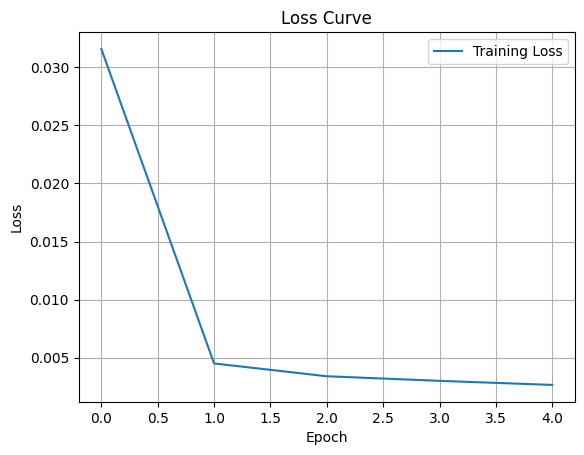

In [30]:
# plotting loss...
plt.plot(train_losses, label='Training Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.show()

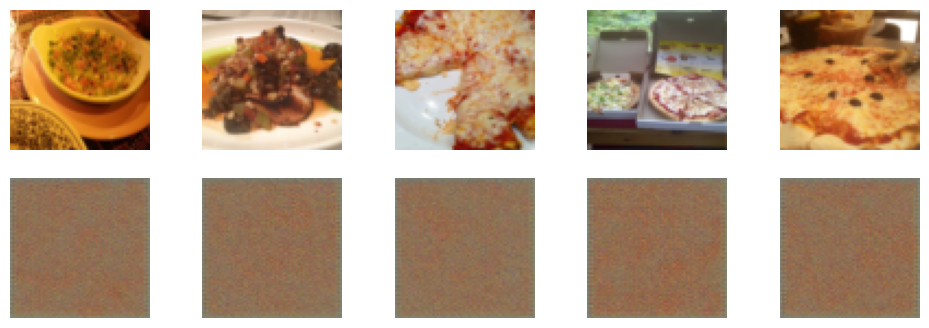

In [31]:
vae.eval()
images, _ = next(iter(vae_test_loader))
with torch.no_grad():
    recon, _, _ = vae(images)

n = 5
fig, axes = plt.subplots(2, n, figsize=(12,4))
for i in range(n):
    axes[0, i].imshow(images[i].permute(1,2,0).cpu().numpy())
    axes[0, i].axis('off')
    axes[1, i].imshow(recon[i].permute(1,2,0).cpu().numpy())
    axes[1, i].axis('off')
plt.show()


In [ ]:
for images, _ in trainLoader:   # ignore labels
    outputs, mu, logvar = vae(images)
    loss = vae_loss(outputs, images, mu, logvar)

## Part3...